# Machine Learning Task

Features Selection with Wrapper Method

---

## Introduction

Author : Anas Rashidi <br>
NPM  : 2402345425
<br>
<br>

## About the dataset

__Context__
It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

__Content__
The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.



You could download dataset from [here](https://www.kaggle.com/mlg-ulb/creditcardfraud)
<br>
<br>

## Goals

1. How many anomaly / fraud transaction happening in 2 days?
2. How is the time trend of anomaly transaction of credit card?
3. How is the amount trend of anomaly transaction of credit card?
4. Create a model which could predict the anomaly of transaction and labeled it as fraudness transaction /positive result with minimum false negative prediction.



## Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Loading

In [ ]:
#Load Data
data = pd.read_csv("creditcard.csv")
data.head(2)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


In [ ]:
#Shape of Data
data.shape

(284807, 31)

We have 284.807 data with 31 columns. In this context, column Class is our target column while the rest become our features.

## Data Cleaning

In [ ]:
#Copy data
df = data.copy()

In [ ]:
#Check Missing Value
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

We don't have any null value. If there is in future new data, we will drop it.

Recalling dataset information, we already have clean data and scaled features except Amount and Time. For confidential purpose, the rest of features (V1 - V28) already been processed PCA.

## Data Visualization

We will split data fraud transaction (class = 1) and normal transaction (class=0)

In [ ]:
#Split data normal vs fraud
df_normal = df[df["Class"] == 0]
df_fraud = df[df["Class"] == 1]

__Distribution of normal transaction__

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


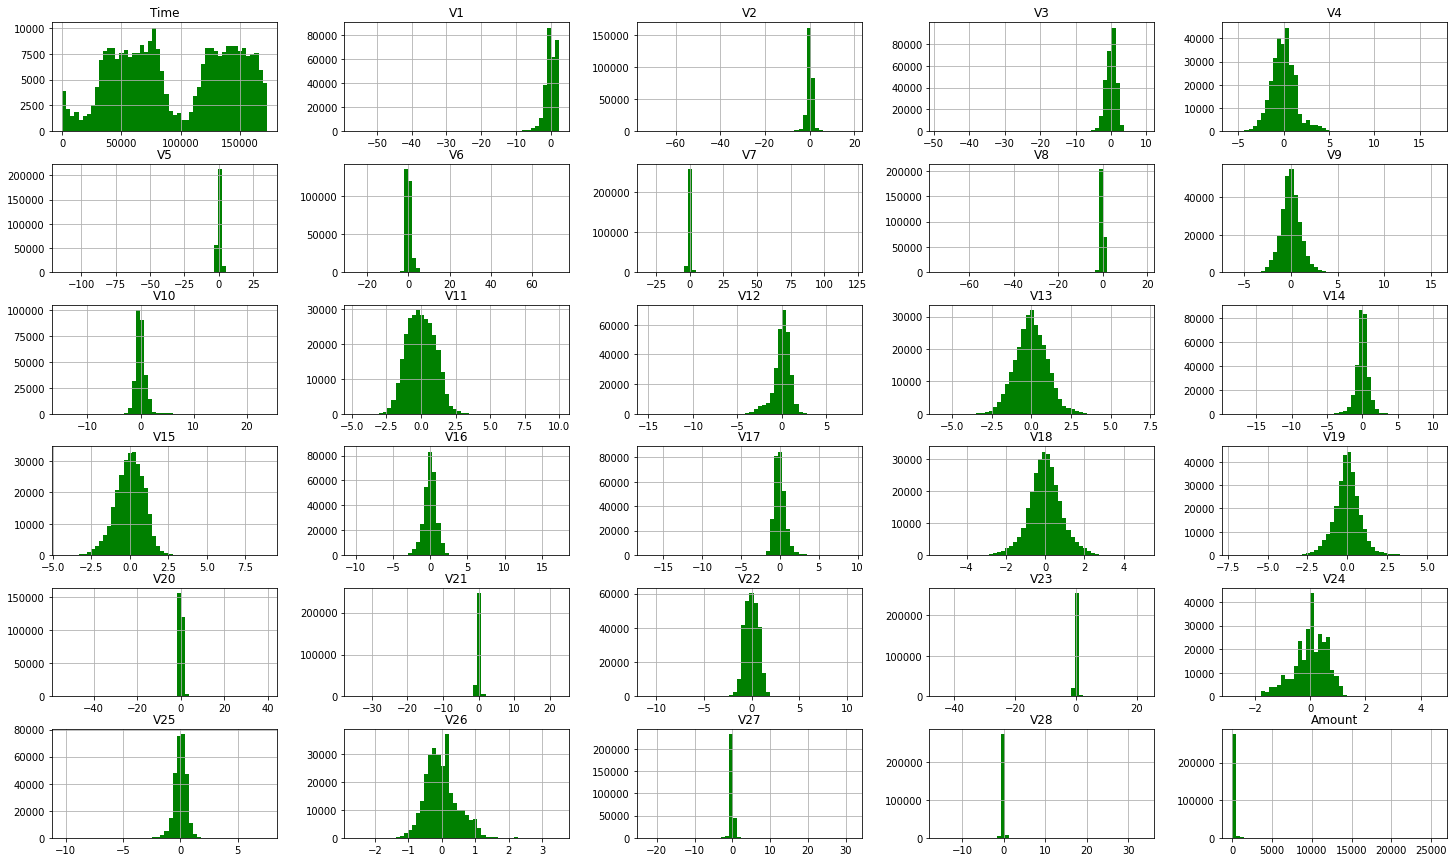

In [ ]:
#Data Distribution of normal transaction
fig,ax = plt.subplots(figsize=(25,15))
df_normal.iloc[:,:-1].hist(ax=ax, bins=50 , color="green")
plt.show()

From above distribution of normal data we could see some information :
- Almost all of features looks distributed normally at first except Time and Amount.  We could use modelling which using gaussian distribution as it base.
- Focusing at Time distribution, in 2 days mostly normal transaction is happening in day time and decreasing in night time.
- Focusing at Amount distribution, it's not normally distributed. It's tend to has right skewed means amount of normal transaction has high variance untul 25000 but the mean is far away below.



__Distribution of Fraud Transaction__

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


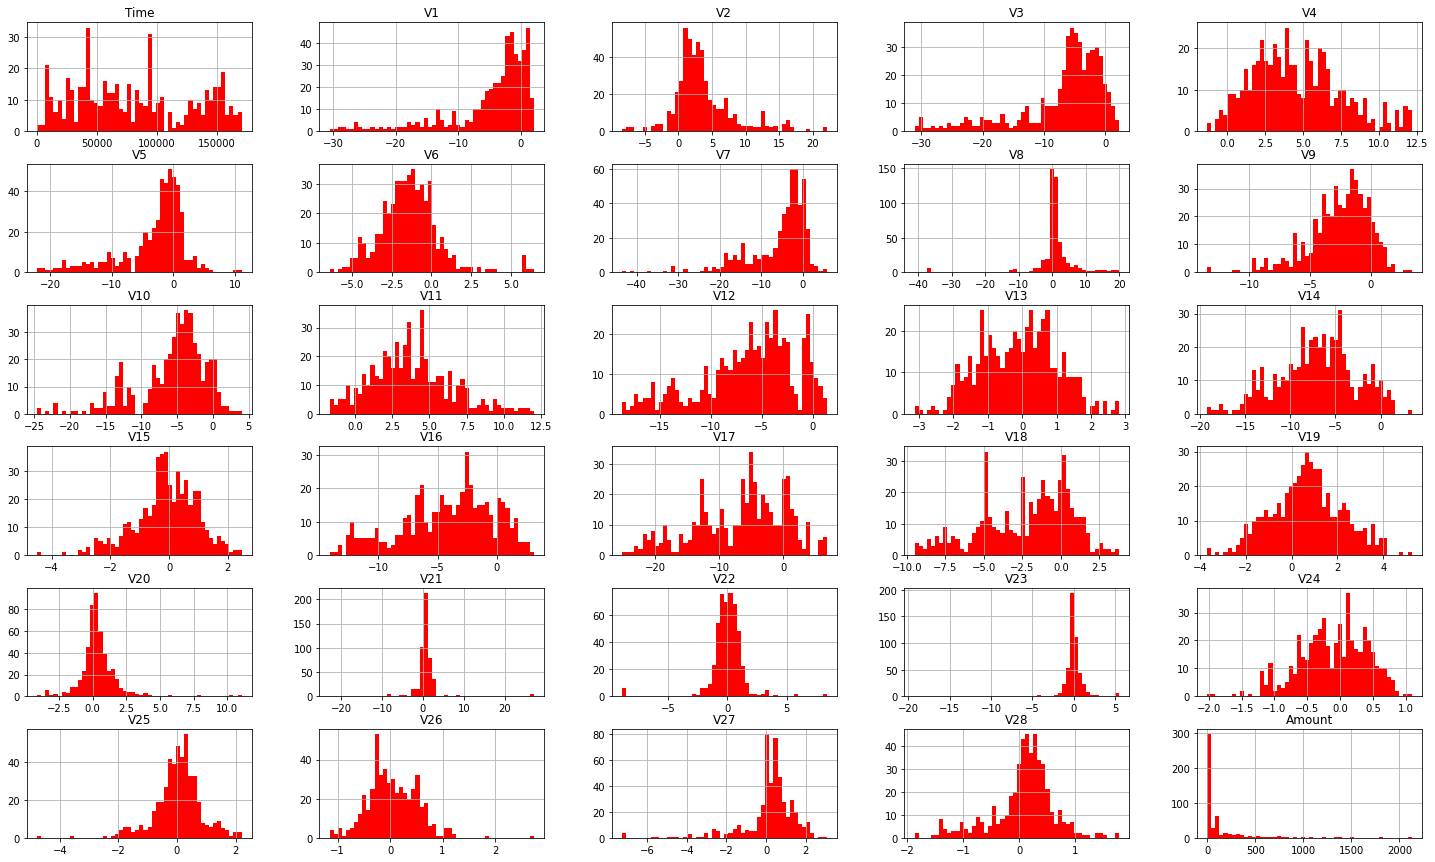

In [ ]:
#Data Distribution of fraud transaction
fig,ax = plt.subplots(figsize=(25,15))
df_fraud.iloc[:,:-1].hist(ax=ax, bins=50 , color="red")
plt.show()

At a glance , distribution of fraudness transaction are similar with normal transaction. Almost of the features distribution has normal distribution with some skewed of data except Time and Amount. From time perspective, fraud transacation pattern seems intentionally made to be similar with normal transaction. They do fraud in day time mostly to pretend as normal transaction.

From those information, we could see the person who do fraudness transaction might already a pro because they made a fraud transaction which looks like normal transaction.

In this stage, it supposed to be difficult to classify which transaction is fraud or normal. So we might consider anomaly detection in future machine learning for this problem.

__Portion of Fraud Transaction__

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  import sys


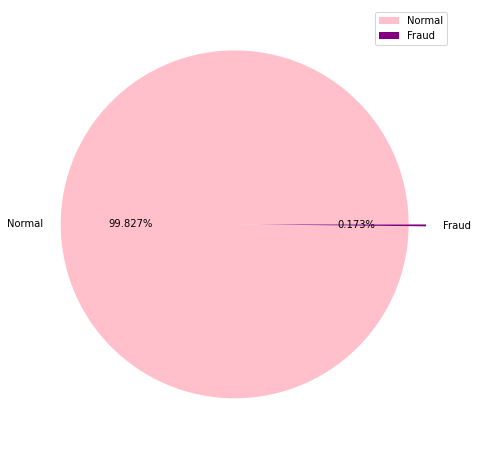

,Class,Time
0,0,284315
1,1,492


In [ ]:
#Query
q1 = df.groupby("Class")["Time"].count().reset_index()

#Graph
plt.figure(figsize=(10,8))
plt.pie(q1["Time"], labels=["Normal", "Fraud"], autopct='%.3f%%', explode=[0,0.1], colors =["pink", "purple"])
plt.legend(q1["Time"], labels=["Normal", "Fraud"])
plt.show()

q1

From 2 days transaction, we have really small portion of fraud transaction which 0,173% only. Eventhough this number portion is so small, still it has high quantity in 2 days which 492 fraudness transaction only in 2 days.

We also conclude the data is highly imbalanced.

__Time Trend of Fraud Transaction__


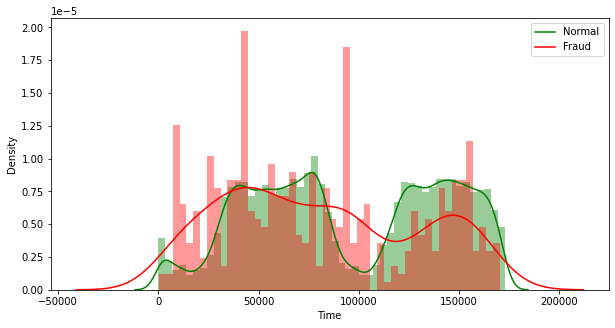

In [ ]:
#Graph
warnings.filterwarnings("ignore")
plt.figure(figsize=(10,5))
sns.distplot(df[df["Class"] == 0]['Time'], bins=50, color="g")
sns.distplot(df[df["Class"] == 1]['Time'], bins=50, color="r")
plt.legend(labels=["Normal", "Fraud"])
plt.show()


Above graph is representing the time of 2 days transaction in seconds from the first transaction.

We could see,there is no spesific time of fraud transaction. Its trend seems similar with the normal transaction. The people who does those fraud seems like a pro because they might try to pretend as normal transaction.

__Amount Trend of Fraud Transaction__


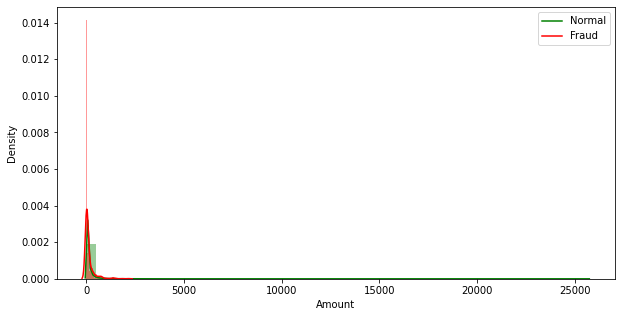

In [ ]:
#Graph
warnings.filterwarnings("ignore")
plt.figure(figsize=(10,5))
sns.distplot(df[df["Class"] == 0]['Amount'], bins=50, color="g")
sns.distplot(df[df["Class"] == 1]['Amount'], bins=50, color="r")
plt.legend(labels=["Normal", "Fraud"])
plt.show()


We could see, mostly trend of fraud transaction tends to have small amount. Maybe it's their strategy to trick the credit card security evaluation since people tend to more focus in transaction with high value.

## Data PreProcessing
Since goals is to make cluster from dataset, we will only use numerical feature.

We will do some preprocesing :
- Scaling our numeric data
- Check MultiCollinearity
- Dimensionality Reduction

### Split Data

In this section, we will split our dataset into 3 set of data :
1. Train data : contains only the normal transaction
2. Eval data: contains 25% of normal and fraud transaction
3. Test data : contains 25% of normal and fraud transaction

In [ ]:
#split data to train ,test and sample
mid = int( 0.6*len(df[df["Class"]==0])+1) #find mid index of normal data

train_df = df[df["Class"]==0].iloc[0:mid, :]
datamodel = df.drop(list(train_df.index))
eval_df, test_df = train_test_split(datamodel, test_size=0.5, random_state=42 , shuffle=True , stratify=datamodel["Class"])

test_df = test_df.reset_index(drop=True)
train_df = train_df.reset_index(drop=True)
eval_df = eval_df.reset_index(drop=True)

print("Total of training data   : ", train_df.shape[0])
print("Total of evaluation data : ", eval_df.shape[0])
print("Total of testing  data   : ", test_df.shape[0])

Total of training data   :  170590
Total of evaluation data :  57108
Total of testing  data   :  57109


In [ ]:
#Split features and y target(class) of each dataset
X_train = train_df.drop(["Class"], axis=1)
X_eval = eval_df.drop(["Class"], axis=1)
X_test = test_df.drop(["Class"], axis=1)

### Wrapped Method Feature Selection

In this method, a subset of features are selected and train a model using them.

In [ ]:
#Define Scaler
scaler = StandardScaler()

#Fit and transform numerical data
X_train["Amount"] = scaler.fit_transform(np.asarray(train_df["Amount"]).reshape(-1, 1))
X_train["Time"] = scaler.fit_transform(np.asarray(train_df["Time"]).reshape(-1, 1))

X_eval["Amount"] = scaler.transform(np.asarray(eval_df["Amount"]).reshape(-1, 1))
X_eval["Time"] = scaler.transform(np.asarray(eval_df["Time"]).reshape(-1, 1))

X_test["Amount"] = scaler.transform(np.asarray(test_df["Amount"]).reshape(-1, 1))
X_test["Time"] = scaler.transform(np.asarray(test_df["Time"]).reshape(-1, 1))

### Check Multicollinearity Features


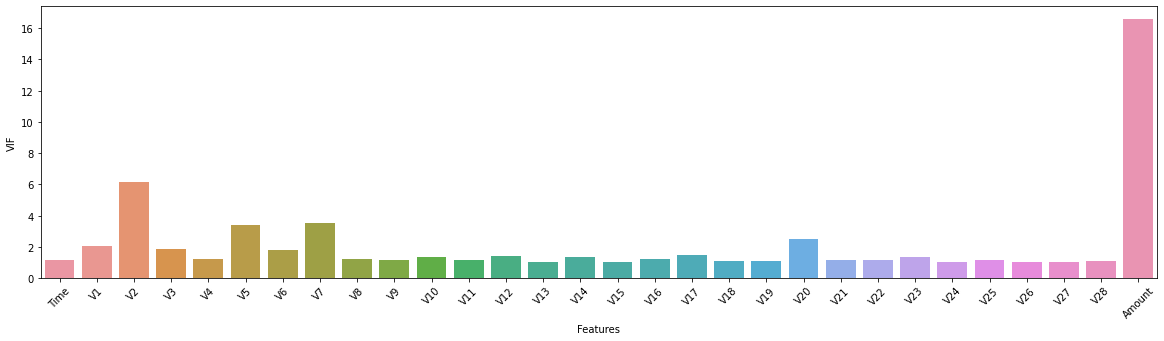

,Features,VIF
0,Time,1.177151
1,V1,2.084309
2,V2,6.154232
3,V3,1.881227
4,V4,1.249037
5,V5,3.418530
6,V6,1.795658
7,V7,3.502488
8,V8,1.200939
9,V9,1.151635


In [ ]:
#Define VIF dataFrame
vif_data= pd.DataFrame()
vif_data["Features"] = X_train.columns

#Calculate VIF
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                    for i in range(len(X_train.columns))]

#Graph
plt.figure(figsize=(20,5))
sns.barplot(x=vif_data["Features"], y=vif_data["VIF"])
plt.xticks(rotation=45)
plt.show()

vif_data

From above VIF, only Amount which has multicollinearity higher than 5. It might has strong correlation with other feature. So we won't use it for modeling. And also since there is not any features with high VIF again, means we might couldn't reduce the features to lower dimension anymore with PCA or else.

In [ ]:
#Drop Amount from all of our dataset
X_train.drop(["Amount"], axis=1, inplace= True)
X_eval.drop(["Amount"], axis=1, inplace= True)
X_test.drop(["Amount"], axis=1, inplace= True)

### Feature Selection with Correlation

For feature selection, we will back to our previous all dataset and comparing the distribution of normal transaction vs fraudness transaction in every features. The goals is we want to identify which features who can't distinguish normal vs fraudness transaction.

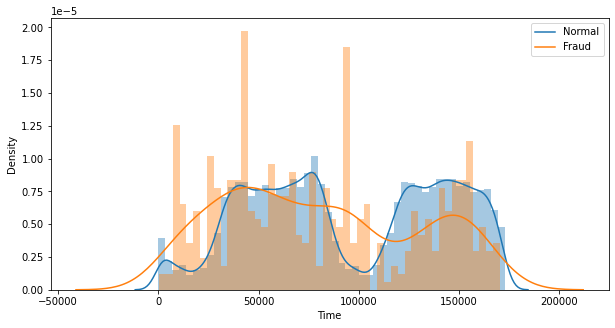

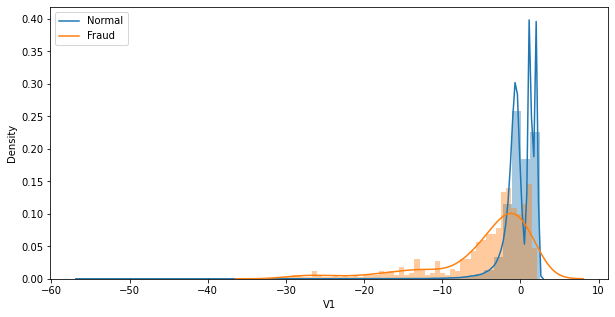

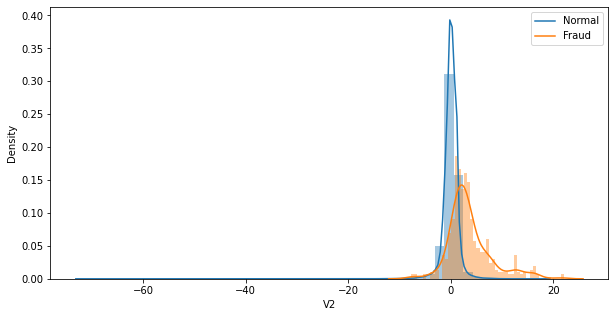

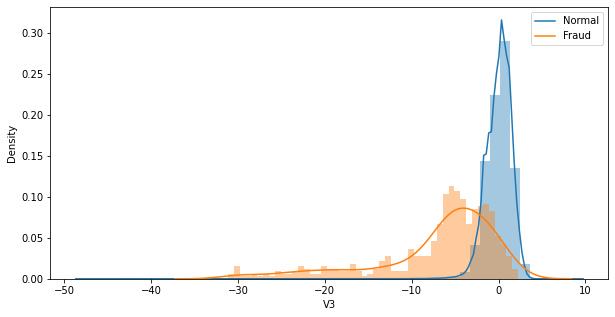

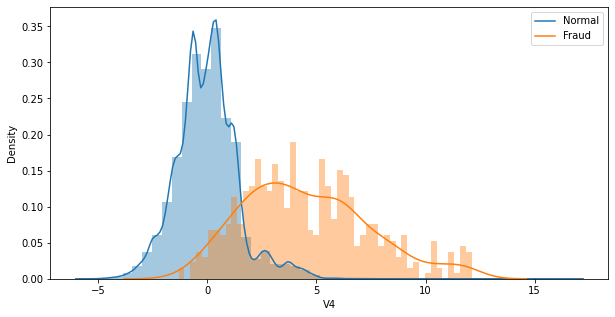

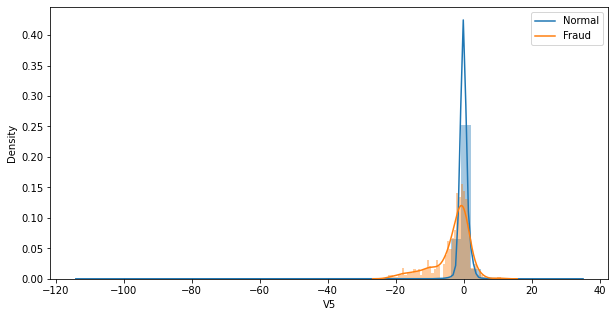

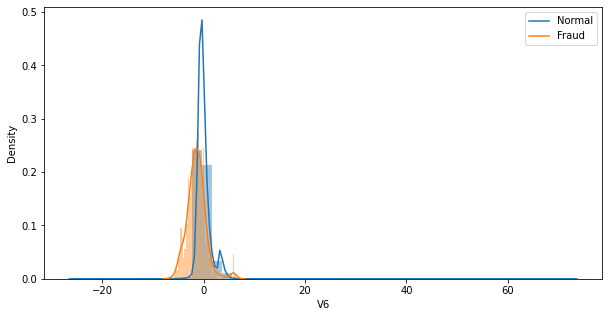

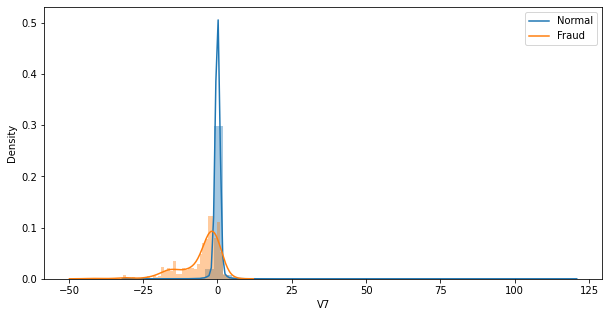

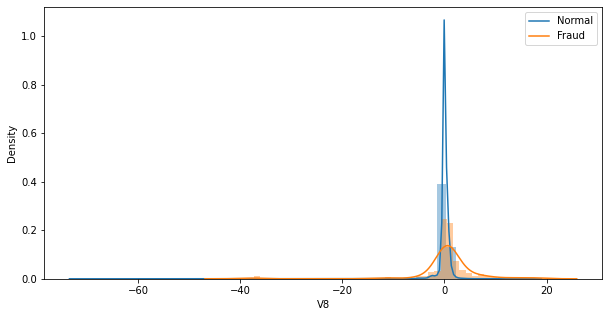

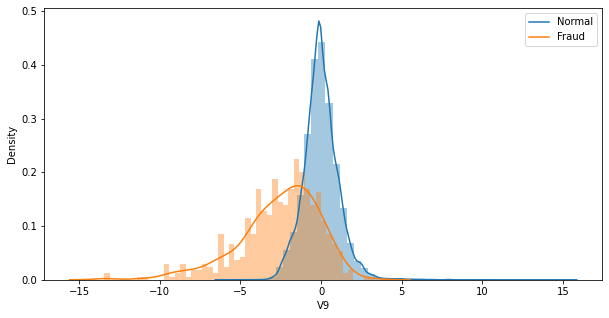

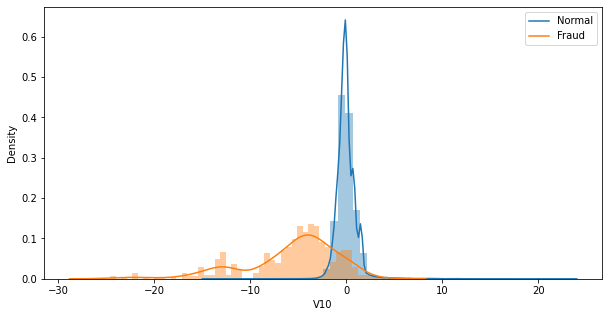

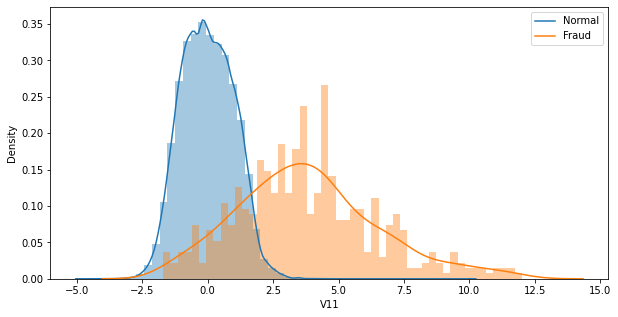

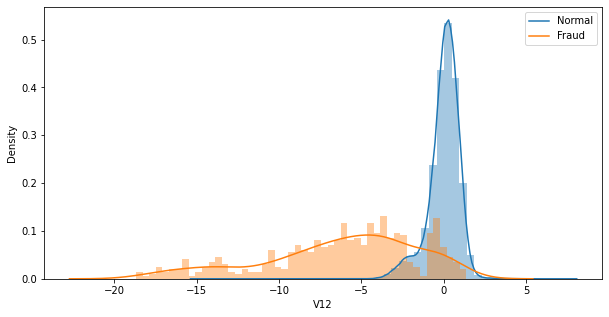

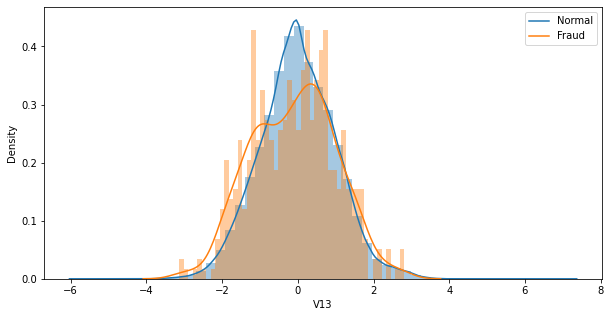

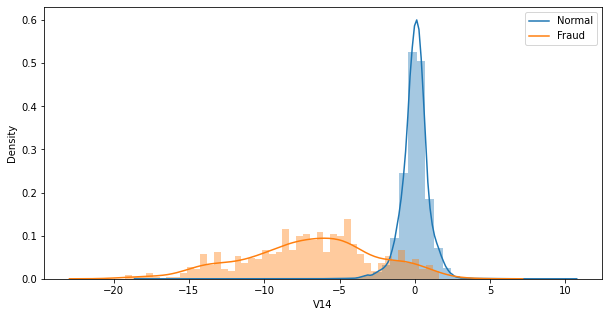

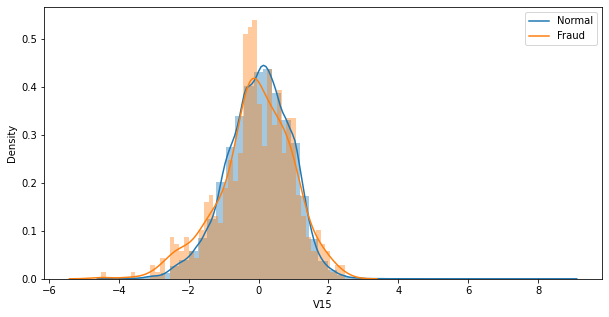

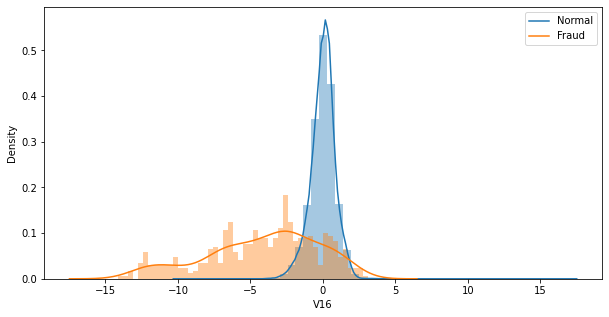

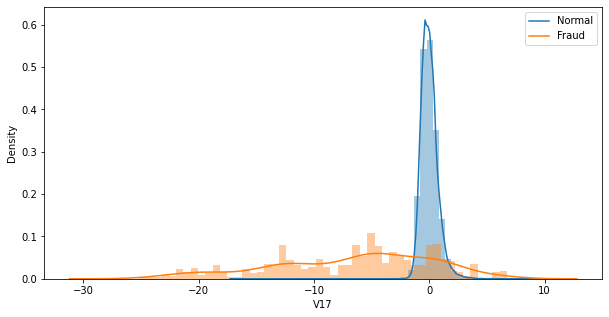

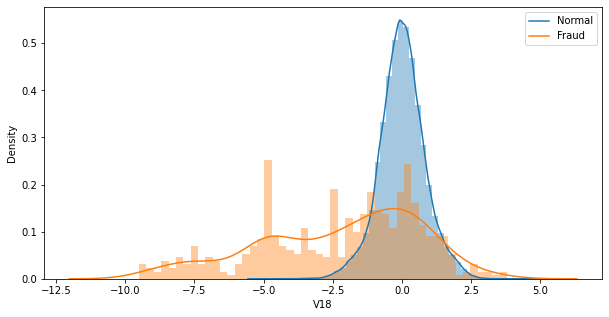

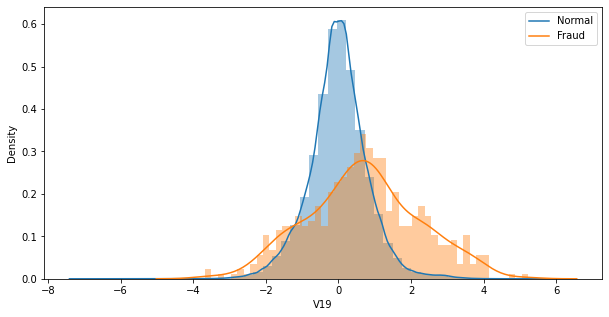

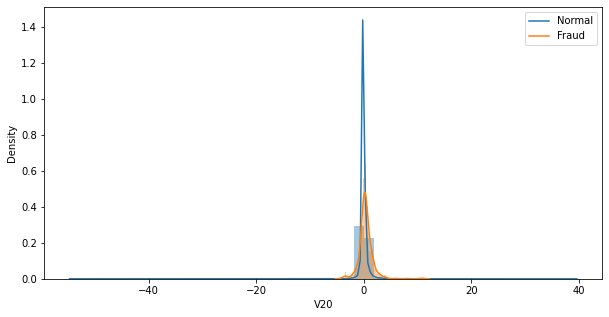

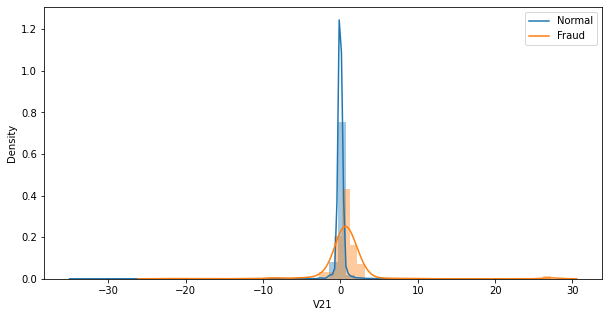

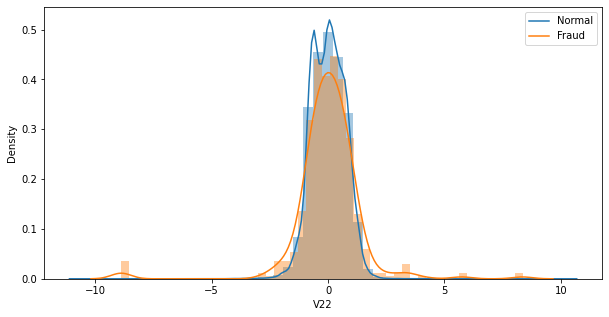

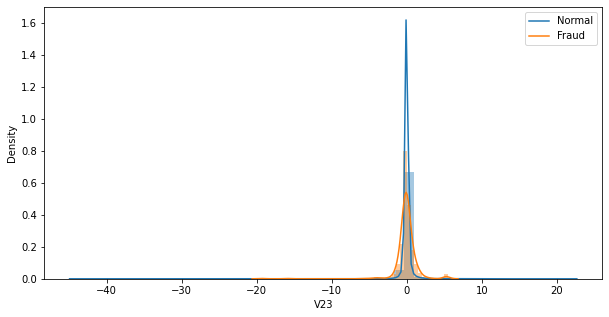

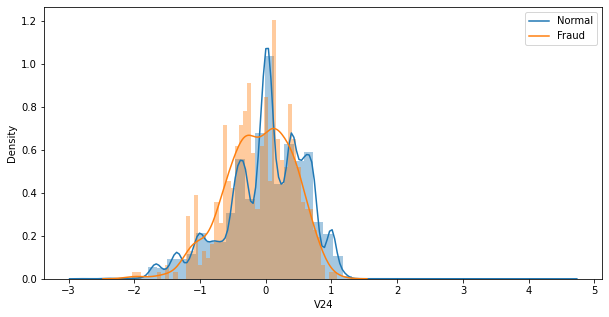

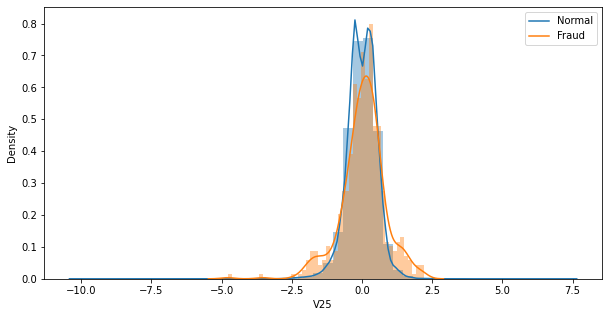

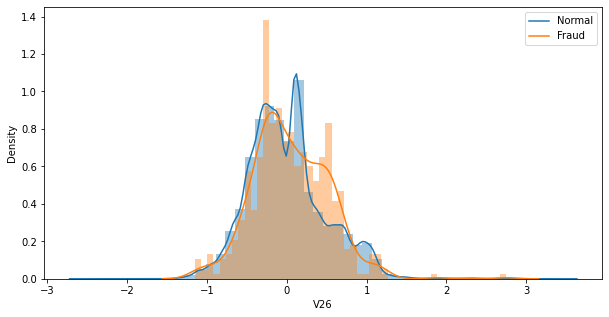

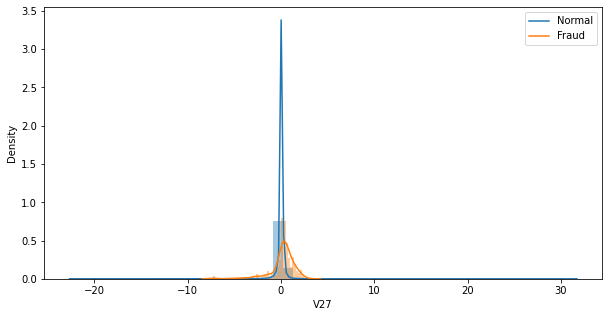

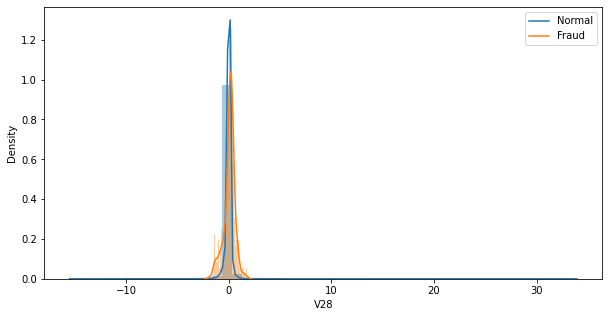

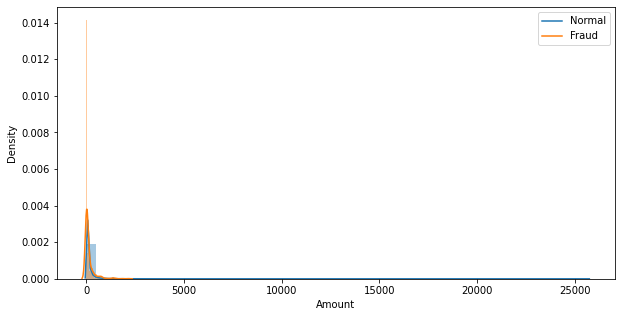

In [ ]:
#Graph
for i in list(df.iloc[:,:-1].columns):

  warnings.filterwarnings("ignore")
  plt.figure(figsize=(10,5))
  sns.distplot(df[df["Class"] == 0][i], bins=50)
  sns.distplot(df[df["Class"] == 1][i], bins=50)
  plt.legend(labels=["Normal", "Fraud"])
  plt.show()


From above graph, we could see features "Time","V13","V15","V20","V22", "V23", "V24","V25","V26","V28", "Amount" of fraud transaction has almost same distribution with normal transaction. So we will drop it for the model later.

We've already drop Amount before,so we will only remove the rest here.

In [ ]:
#Final Feature for train data
X_train = X_train.drop(["Time","V13","V15","V20","V22", "V23", "V24","V25","V26","V28"], axis=1)

#Final Feature for eval and test data
X_eval = X_eval.drop(["Time","V13","V15","V20","V22", "V23", "V24","V25","V26","V28"], axis=1)
X_test = X_test.drop(["Time","V13","V15","V20","V22", "V23", "V24","V25","V26","V28"], axis=1)

X_train.shape[1]

19

Now, we only have 19 features left.

## Model Definition and Train

__Find out the best n_components of Gaussian Mixsture Clustering model__

We will find the best n components by BIC and AIC Values. The lowest values of BIC and AIC are the good one.

In [ ]:
#train gaussianMixsture with several component
#Unhash code below to run the iteration (It will take long time)

#gms_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X_train) for k in range(6, 9)]

In [ ]:
#calculate BIC and AIC
#Unhash code below to run code

#bics = [model.bic(X_train) for model in gms_k]
#aics = [model.aic(X_train) for model in gms_k]

Text(0, 0.5, 'AIC Value')

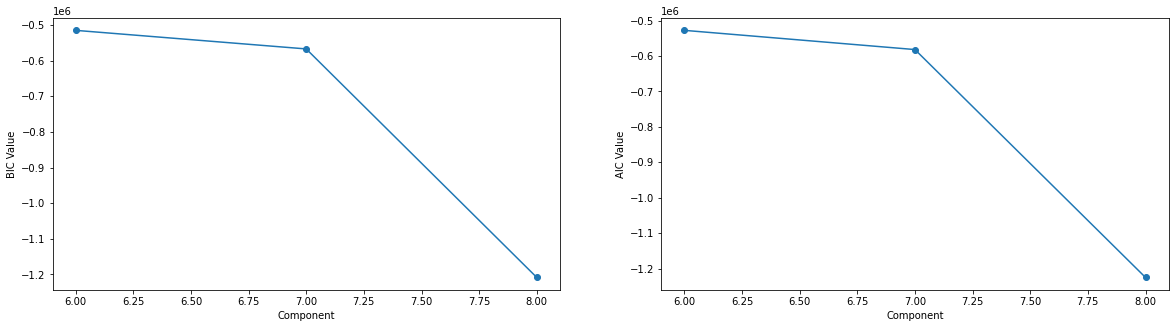

In [ ]:
#Graph
#Unhash code below to run code

#fig,ax = plt.subplots(ncols=2, figsize=(20,5))
#ax[0].plot(range(6,9), bics ,marker='o')
#ax[0].set_xlabel('Component')
#ax[0].set_ylabel('BIC Value')
#ax[1].plot(range(6,9), aics ,marker='o')
#ax[1].set_xlabel('Component')
#ax[1].set_ylabel('AIC Value')


We've done run code above and resulting the best cluster with lowest BIC and AIC value is 8.


_*We might test n_components over 8 but it takes so many time so we will put maximum only 8 component_

### Final Model Gaussian

In [ ]:
#Build Model Final
model = GaussianMixture(n_components=8 , random_state=42, n_init=10)

In [ ]:
#Train the model (Takes 15 Minutes to run )
model.fit(X_train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=8, n_init=10,
                precisions_init=None, random_state=42, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [ ]:
#Predict the model density
density = model.score_samples(X_train)

With density of every datapoint of train data, we will put treshold and make it become our filter between normal and fraud data.

## Model Evaluation

### Selecting Best Density of Treshold

In anomaly context, eventhough our best model has n cluster, but we will re-labeling the cluster with 0 and 1 like the raw dataset based on treshold of density of each data point. Density for each datapoint is related to it's center of cluster. Every datapoint who has density against its own cluster center , which the value is below treshold will be labelled as 1 (fraud) while the rest of datapoint in all cluster will be labled as 0 (normal).

In this section, we will try several treshold and find out the best treshold which produce good evaluation Metrics.

Here, we will concern to label 1 which fraud transaction will be positive value. So, to get the best treshold, we want get maximum value of recall since we want to minimize the model to predict a fraud transaction as normal transaction (false negative). Also, we will consider the F1 Score and AUC Score.

In [ ]:
#Predict evaluation set density
y = model.score_samples(X_eval)

In [ ]:
#Evaluation against some  treshold value

ths =[]
prcs=[]
recs=[]
f1s =[]
rocs=[]
fprs=[]
tprs=[]
treshold = [np.percentile(density, i) for i in [0.75,0.5,0.45, 0.25,0.10]] #define list of treshold from train set data density

for th in treshold :
  y_pred_eval = [0 if x > th else 1 for x in y ] #classify normal vs fraud transaction based on density

  prc = classification_report(eval_df["Class"], y_pred_eval, output_dict=True)['1']['precision'] #calculate precision against fraud transaction
  rec = classification_report(eval_df["Class"], y_pred_eval, output_dict=True)['1']['recall']    #calculate recall against fraud transaction
  f1 = classification_report(eval_df["Class"], y_pred_eval, output_dict=True)['1']['f1-score']   #calculate f1 score against fraud transaction

  roc = roc_auc_score(eval_df["Class"], y_pred_eval)  #calculate AUC score against fraud transaction
  fpr, tpr, thresholds = roc_curve(eval_df["Class"], y_pred_eval) #calculate fpr and tpr values against fraud transaction

  ths.append("Treshold %.2f" %th)
  prcs.append(round(prc,2))
  recs.append(round(rec,2))
  f1s.append(round(f1,2))
  rocs.append(round(roc,2))
  fprs.append(fpr)
  tprs.append(tpr)

eval = pd.DataFrame({"Treshold": ths,"Precision": prcs,"Recall": recs,"F1-Score": f1s,"AUC Score": rocs,"FPR": fprs,"TPR": tprs})

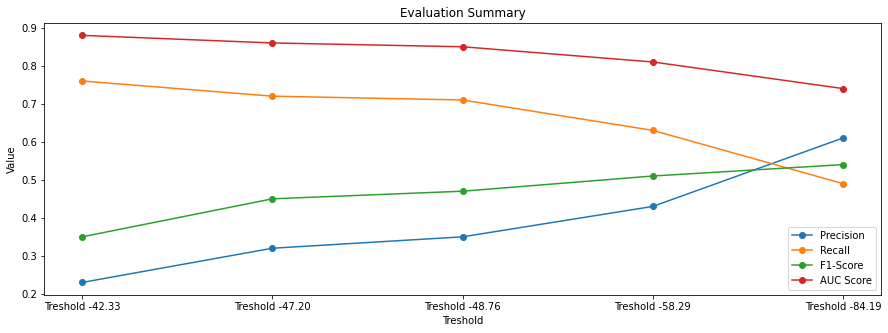

,Treshold,Precision,Recall,F1-Score,AUC Score
0,Treshold -42.33,0.23,0.76,0.35,0.88
1,Treshold -47.20,0.32,0.72,0.45,0.86
2,Treshold -48.76,0.35,0.71,0.47,0.85
3,Treshold -58.29,0.43,0.63,0.51,0.81
4,Treshold -84.19,0.61,0.49,0.54,0.74


In [ ]:
#Evaluation Summary
#Graph
plt.figure(figsize=(15,5))
plt.plot(eval["Treshold"],eval["Precision"], marker="o", label="Precision")
plt.plot(eval["Treshold"],eval["Recall"], marker="o", label="Recall")
plt.plot(eval["Treshold"],eval["F1-Score"], marker="o", label="F1-Score")
plt.plot(eval["Treshold"],eval["AUC Score"], marker="o", label="AUC Score")
plt.xlabel("Treshold")
plt.ylabel("Value")
plt.legend(loc="best")
plt.title("Evaluation Summary")
plt.show()

eval[["Treshold","Precision","Recall","F1-Score", "AUC Score"]]

From above summary result, we want to choose treshold of density with high recall value and fair AUC Score. So our choice is Model with Treshold -42.33.

It has 76% ability to not predict fraud transaction as normal transaction. Eventhought the precision is very low, it's okay because we want to focus only minimize the loss caused by fraud transaction. Let's we see how the AUC Score is graphed in this context.

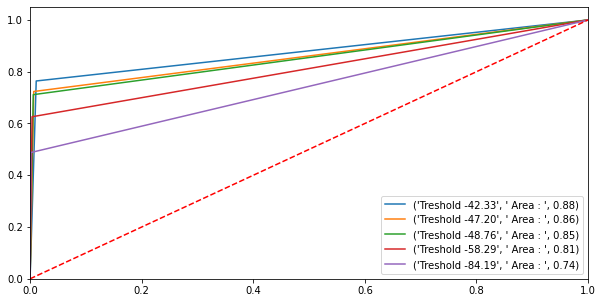

In [ ]:
#Graph AUC Score
plt.figure(figsize=(10,5))
plt.plot(eval["FPR"][0], eval["TPR"][0], label= (eval["Treshold"][0] , " Area : ", eval["AUC Score"][0]))
plt.plot(eval["FPR"][1], eval["TPR"][1], label= (eval["Treshold"][1] , " Area : ", eval["AUC Score"][1]))
plt.plot(eval["FPR"][2], eval["TPR"][2], label= (eval["Treshold"][2] , " Area : ", eval["AUC Score"][2]))
plt.plot(eval["FPR"][3], eval["TPR"][3], label= (eval["Treshold"][3] , " Area : ", eval["AUC Score"][3]))
plt.plot(eval["FPR"][4], eval["TPR"][4], label= (eval["Treshold"][4] , " Area : ", eval["AUC Score"][4]))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right")
plt.show()

From AUC Score, treshold -42.33 also has widest score area (88%) and it means good for model.

### Final Model Treshold


In [ ]:
#Final Treshold
trs_fin = np.percentile(density, 0.75)

print("Final Treshold will be used : %.2f" % trs_fin)

Final Treshold will be used : -42.33


In [ ]:
#Final Prediction Class
y_pred_eval = [0 if x > th else 1 for x in y ]

We've decided our final model and treshold. So let's look at the distribution of dataset. In this context we will use reduction PCA into 2D for visualization only eventhough it might not represent all of the data.

In [ ]:
#Create mode PCA 2 Dimensions
pca2d = PCA(n_components=2)
X_eval2d = pca2d.fit_transform(X_eval)

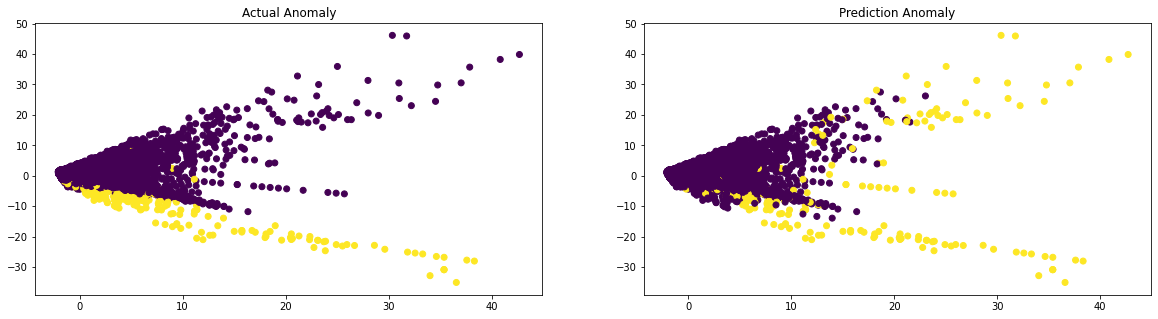

In [ ]:
#Graph
fig, ax = plt.subplots(1,2,figsize=(20,5))

ax[0].scatter(X_eval2d[:,0],X_eval2d[:,1],c=eval_df['Class']);
ax[0].set_title("Actual Anomaly")
ax[1].scatter(X_eval2d[:,0],X_eval2d[:,1],c=y_pred_eval);
ax[1].set_title("Prediction Anomaly")

plt.show()


We could see the yellow dots of data which represent the anomaly transaction and the purple one represents normal data.

Almost of all yellow dot of actual data from the left graph are represented in the right graph eventhough in the right graph we have more yellow dot which should be the purple one. It's better to suspect a transaction as fraud than doesn't suspect it while it's a true fraud.

## Model Inference

In this section we will use our previous test dataset to inference our final model.

In [ ]:
#Predict density of datapoint
y_test = model.score_samples(X_test)

#Labeling the class
y_pred_test = [0 if x > trs_fin else 1 for x in y_test]

#Summary Result Test
result = pd.DataFrame({"Class":test_df["Class"], "Pred_Class":y_pred_test})

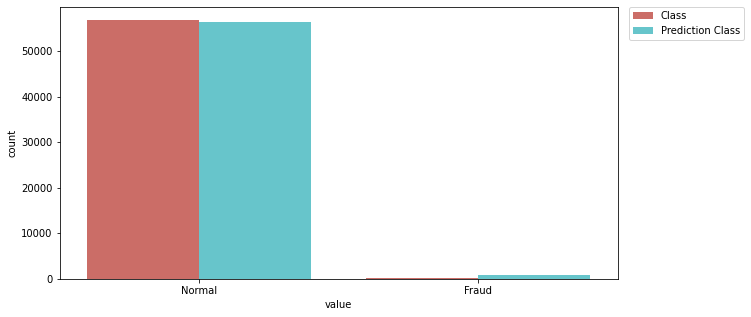

In [ ]:
#Graph
gr = pd.melt(result)
plt.figure(figsize=(10,5));
g1 =sns.countplot(data=gr, x="value",  palette="hls", hue="variable")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0 , labels=['Class', 'Prediction Class'])
g1.set_xticklabels(['Normal', 'Fraud'])
plt.show()


We could see above graph, the test result did what we expected. Total fraud transaction the model detected is not lower than the actual. With this model we might could decrease the fraud transaction happening.

## Conclusion

From above activites we've done, here some conclusion we got :

1. From 2 days transaction, we have really small portion of fraud transaction which 0,173% only. Eventhough this number portion is so small, still it has high quantity in 2 days which 492 fraudness transaction only in 2 days.
2. There is no spesific time of fraud transaction. Its trend seems similar with the normal transaction. The people who does those fraud seems like a pro because they might try to pretend as normal transaction.
3. Mostly trend of fraud transaction tends to have small amount. It's might be their strategy to trick the credit card security evaluation since people tend to more focus in transaction with high value.
4. To detect the anomaly of credit card transaction as fraud transaction we have choosed the best model using Gaussian Mixsture. It's resulting 8 cluster of data and from those cluster we've decided the treshold of distance/density of datapoint against its own cluster. The best treshold is -42.33 which could decide which transaction is fraud or normal. If the datapoint is below the treshold, it would classified the model as fraud/anomaly. This model has 76% ability to not predict fraud transaction as normal transaction, inline with the goals of company.